# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click !here goes the icon of the corresponding button in the gutter! button.
To debug a cell, press Alt+Shift+Enter, or click !here goes the icon of the corresponding button in the gutter! button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/jupyter-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [249]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [250]:
image = cv2.imread('./data/30_0_4_20170117153249558.jpg.chip.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [251]:
image.shape

(200, 200, 3)

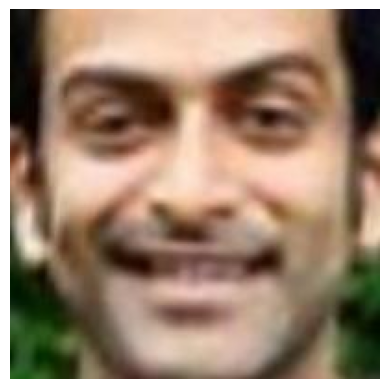

In [252]:
plt.imshow(image)
plt.axis('off') 
plt.show()

In [253]:
# scale_down = 1  
# scale_up = 1   
resized_image = cv2.resize(image, (200,200), interpolation=cv2.INTER_LANCZOS4)

In [254]:
resized_image.shape

(200, 200, 3)

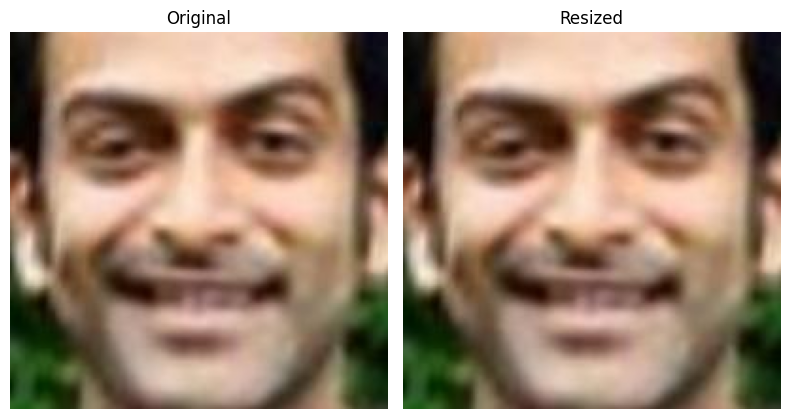

In [255]:
fig, axes = plt.subplots(1, 2, figsize=(8, 5))

# First subplot
axes[0].imshow(image, cmap='gray')
axes[0].set_title(f"Original")
axes[0].axis('off')

# Second subplot
axes[1].imshow(resized_image, cmap='gray')
axes[1].set_title(f"Resized")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [256]:
def preprocess_image(image, clip_limit=2.0):    
    # # Convert to YCrCb color space for better contrast enhancement
    ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(ycrcb)
    y_channel_stretched = cv2.normalize(y, None, 0, 255, cv2.NORM_MINMAX)

    # # Apply CLAHE (Adaptive Histogram Equalization) on the Y (luminance) channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(3,3))
    y_clahe = clahe.apply(y_channel_stretched)


    # # Merge and convert back to RGB
    image = cv2.merge([y_clahe, cr, cb])
    image = cv2.cvtColor(image, cv2.COLOR_YCR_CB2RGB)
    
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(image, (3,3), 0)

    # Aplly sharpening
    sharpen_kernel = np.array([
        [0, -1,  0],
        [-1, 5, -1],
        [0, -1,  0]
    ])
    sharpened = cv2.filter2D(blurred, -1, sharpen_kernel)

    return sharpened

In [257]:
enhaced = preprocess_image(cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR))

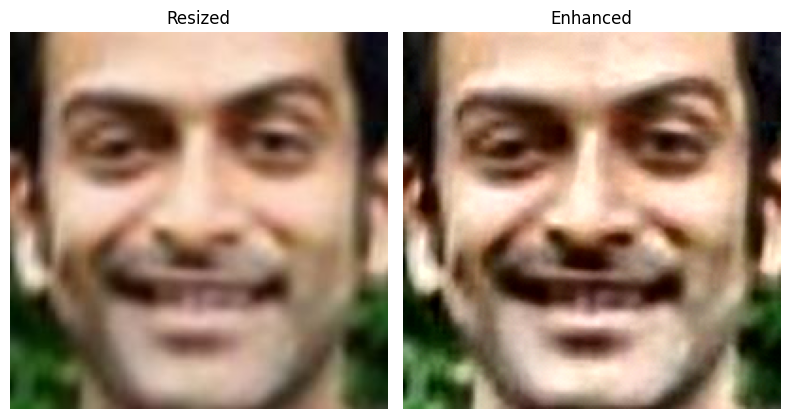

In [258]:
fig, axes = plt.subplots(1, 2, figsize=(8, 5))
# Second subplot
axes[0].imshow(resized_image, cmap='gray')
axes[0].set_title(f"Resized")
axes[0].axis('off')

# First subplot
axes[1].imshow(enhaced, cmap='gray')
axes[1].set_title(f"Enhanced")
axes[1].axis('off')


plt.tight_layout()
plt.show()

In [259]:
from fapnet import FAPNet

In [260]:
import torch

file_name = "./models/human_age_prediction_challenger.pt"
model = torch.load(file_name, map_location='cpu', weights_only=False)

In [275]:
def get_prediction(image):
    # Si enhaced est un numpy array, convertis-le
    if isinstance(image, np.ndarray):
        image = torch.from_numpy(image)
    
    # print("Original shape:", enhaced.shape)
    
    # Squeeze all dimensions of size 1 to remove extra dimensions
    image = image.squeeze()
    # print("After squeeze:", enhaced.shape)
    
    # Vérifie que le type est float
    if image.dtype != torch.float32:
        image = image.float()
    
    # Normalise si nécessaire (si les valeurs sont dans [0,255])
    if image.max() > 1.0:
        image = image / 255.0
    
    # Si nécessaire, permute les dimensions de (H, W, C) à (C, H, W)
    if image.ndim == 3 and image.shape[2] == 3:
        image = image.permute(2, 0, 1)
        # print("After permute (C, H, W):", enhaced.shape)
    
    # Ajoute UNE SEULE dimension batch pour obtenir (N, C, H, W)
    if image.ndim == 3:  # Si on a (C, H, W)
        image = image.unsqueeze(0)  # Devient (1, C, H, W)
    
    # print("Final shape before model:", enhaced.shape)  # Doit être [1, 3, H, W]
    
    # Passe au modèle
    model.eval()
    with torch.no_grad():
        return model(image)

In [276]:
output = get_prediction(enhaced)

In [277]:
print(output)

tensor([[30.0189]])


In [278]:
def extract_age(filename):
    return int(filename.split("_")[0])

In [279]:
import os

path = './data/'
image_path = []
image_age = []


for image in os.listdir(path):
  image_path.append(path+image)
  image_age.append(extract_age(image))

In [273]:
image_path

['./data/10_0_0_20170110220654150.jpg.chip.jpg',
 './data/24_1_3_20170104231344873.jpg.chip.jpg',
 './data/30_0_4_20170116221659118.jpg.chip.jpg',
 './data/30_0_4_20170117125946865.jpg.chip.jpg',
 './data/30_0_4_20170117153249558.jpg.chip.jpg',
 './data/30_0_4_20170117154305388.jpg.chip.jpg']

In [280]:
for i in range(len(image_path)):
    image = cv2.imread(image_path[i])
    enhanced = preprocess_image(image)
    output = get_prediction(enhanced)
    print(output)

tensor([[16.5169]])
tensor([[27.4036]])
tensor([[28.0033]])
tensor([[36.6755]])
tensor([[30.0189]])
tensor([[28.2735]])
